In [1]:
# disable overly verbose tensorflow logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}   
import tensorflow as tf


import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Flatten, Conv2D, MaxPool2D, Reshape
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# unused for now, to be used for ROC analysis
from sklearn.metrics import roc_curve, auc

allow_growth = True

# the size of the images in the PCAM dataset
IMAGE_SIZE = 96

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [2]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)


input = Input(input_shape)

# get the pretrained model, cut out the top layer
pretrained = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')

# if the pretrained model it to be used as a feature extractor, and not for
# fine-tuning, the weights of the model can be frozen in the following way
# for layer in pretrained.layers:
#    layer.trainable = False

#output = pretrained(input)
#output = GlobalAveragePooling2D()(output)
#output = Dropout(0.5)(output)
#output = Dense(1, activation='sigmoid')(output)

model = Sequential()
model.add(pretrained)
model.add(Flatten())

#Add the Dense layers along with activation and batch normalization
model.add(Dense(1024,activation=('relu'),input_dim=512))
model.add(Dense(512,activation=('relu'))) 
model.add(Dropout(.4))
model.add(Dense(256,activation=('relu'))) 
model.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
model.add(Dense(128,activation=('relu')))
model.add(Dropout(.2))
model.add(Dense(1,activation=('softmax')))

#model = Model(input, output)

# note the lower lr compared to the cnn example
model.compile(SGD(lr=0.001, momentum=0.95), loss = 'binary_crossentropy', metrics=['accuracy'])

# print a summary of the model on screen
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              18875392  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [3]:
def get_pcam_generators(base_dir, train_batch_size=32, val_batch_size=32):

     # dataset parameters
     train_path = os.path.join(base_dir, 'train+val', 'train')
     valid_path = os.path.join(base_dir, 'train+val', 'valid')
	 
     # instantiate data generators
     datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

     train_gen = datagen.flow_from_directory(train_path,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=train_batch_size,
                                             class_mode='binary')

     val_gen = datagen.flow_from_directory(valid_path,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=val_batch_size,
                                             class_mode='binary')

     return train_gen, val_gen

In [4]:
# get the data generators
train_gen, val_gen = get_pcam_generators(r'C:\Users\20153761\Documents\TUe\4e jaar\3e kwartiel\BIA')

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [5]:
# save the model and weights
model_name = 'Resnet50'
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'

model_json = model.to_json() # serialize model to JSON
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json)


# define the model checkpoint and Tensorboard callbacks
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]


# train the model, note that we define "mini-epochs"
train_steps = train_gen.n//train_gen.batch_size//20
val_steps = val_gen.n//val_gen.batch_size//20

# since the model is trained for only 10 "mini-epochs", i.e. half of the data is
# not used during training
history = model.fit_generator(train_gen, steps_per_epoch=train_steps,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=10,
                    callbacks=callbacks_list)

C:\Users\20153761\Anaconda3\envs\8p361\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
225/225 [==============================] - 110s 434ms/step - loss: 0.6419 - accuracy: 0.5006 - val_loss: 0.3633 - val_accuracy: 0.5088

Epoch 00001: val_loss improved from inf to 0.36326, saving model to Resnet50_weights.hdf5
Epoch 2/10
225/225 [==============================] - 92s 410ms/step - loss: 0.3637 - accuracy: 0.5056 - val_loss: 0.2950 - val_accuracy: 0.5075

Epoch 00002: val_loss improved from 0.36326 to 0.29496, saving model to Resnet50_weights.hdf5
Epoch 3/10
225/225 [==============================] - 91s 406ms/step - loss: 0.3050 - accuracy: 0.5077 - val_loss: 0.2808 - val_accuracy: 0.4837

Epoch 00003: val_loss improved from 0.29496 to 0.28081, saving model to Resnet50_weights.hdf5
Epoch 4/10
225/225 [==============================] - 92s 407ms/step - loss: 0.2755 - accuracy: 0.5111 - val_loss: 0.2732 - val_accuracy: 0.4925

Epoch 00004: val_loss improved from 0.28081 to 0.27321, saving model to Resnet50_weights.hdf5
Epoch 5/10
225/225 [=======================

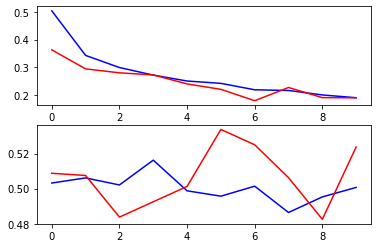

In [6]:
#Plotting the training and validation loss
import matplotlib.pyplot as plt

f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}   
import tensorflow as tf

import numpy as np

import glob
import pandas as pd
from matplotlib.pyplot import imread

from tensorflow.keras.models import model_from_json

#Change these variables to point at the locations and names of the test dataset and your models.
TEST_PATH = r"C:\Users\20153761\Documents\TUe\4e jaar\3e kwartiel\BIA\test\test"
MODEL_FILEPATH = 'Resnet50.json' 
MODEL_WEIGHTS_FILEPATH = 'Resnet50_weights.hdf5'

# load model and model weights
json_file = open(MODEL_FILEPATH, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)


# load weights into new model
model.load_weights(MODEL_WEIGHTS_FILEPATH)


# open the test set in batches (as it is a very big dataset) and make predictions
test_files = glob.glob(TEST_PATH + '\*.tif')

submission = pd.DataFrame()

file_batch = 5000
max_idx = len(test_files)

for idx in range(0, max_idx, file_batch):

    print('Indexes: %i - %i'%(idx, idx+file_batch))

    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]})


    # get the image id 
    test_df['id'] = test_df.path.map(lambda x: x.split(os.sep)[-1].split('.')[0])
    test_df['image'] = test_df['path'].map(imread)
    
    
    K_test = np.stack(test_df['image'].values)
    
    # apply the same preprocessing as during draining
    K_test = K_test.astype('float')/255.0
    
    predictions = model.predict(K_test)
    
    test_df['label'] = predictions
    submission = pd.concat([submission, test_df[['id', 'label']]])


# save your submission
submission.head()
submission.to_csv('submission_resnet1.csv', index = False, header = True)


Indexes: 0 - 5000
Indexes: 5000 - 10000
Indexes: 10000 - 15000
Indexes: 15000 - 20000
Indexes: 20000 - 25000
Indexes: 25000 - 30000
Indexes: 30000 - 35000
Indexes: 35000 - 40000
Indexes: 40000 - 45000
Indexes: 45000 - 50000
Indexes: 50000 - 55000
Indexes: 55000 - 60000
